# Practical Session 5

In [2]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import dlc_practical_prologue as prologue

## Toy data-set

In [6]:
def generate_disc_set(nb):
    X = torch.rand(nb, 2, dtype=torch.float32) * 2 - 1
    Y = (torch.sum(X**2, dim=1) < torch.sqrt(torch.tensor(2/3.141))**2).int()
    return X, Y

X_train, Y_train = generate_disc_set(1000)
X_test, Y_test = generate_disc_set(1000)

# Sanity check:
print(Y_train.sum())

tensor(499)


## Training and test

In [8]:
def train_model(model, train_input, train_target):
    # Params
    eta = 0.1
    mini_batch_size = 100
    nb_epochs = 250

    train_target = train_target.long()

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)

    # Train model
    for e in range(nb_epochs):
            acc_loss = 0
            # Iterate over mini-batches
            for b in range(0, train_input.size(0), mini_batch_size):
                optimizer.zero_grad()
                output = model(train_input.narrow(0, b, mini_batch_size))
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
                loss.backward()
                optimizer.step()

    return model

In [10]:
def compute_nb_errors(model, data_input, data_target):
    # Params
    mini_batch_size = 100

    data_target = data_target.long()

    # Initialization
    e = 0

    # Iterate over mini-batches
    for b in range(0, train_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        classes = data_target.narrow(0, b, mini_batch_size)
        e += (predicted_classes != classes).sum()
        
    return (e / data_target.size(0)).item()

## Models

In [12]:
def create_shallow_model():
    # Params
    n_in = 2
    n_hidden = 128
    n_out = 2

    model = nn.Sequential(
        nn.Linear(n_in, n_hidden, bias=True),
        nn.ReLU(),
        nn.Linear(n_hidden, n_out, bias=True)
    )

    return model

In [14]:
def create_deep_model():
    model = nn.Sequential(
        nn.Linear(2, 4, bias=True),
        nn.ReLU(),
        nn.Linear(4, 8, bias=True),
        nn.ReLU(),
        nn.Linear(8, 16, bias=True),
        nn.ReLU(),
        nn.Linear(16, 32, bias=True),
        nn.ReLU(),
        nn.Linear(32, 64, bias=True),
        nn.ReLU(),
        nn.Linear(64, 128, bias=True),
        nn.ReLU(),
        nn.Linear(128, 2, bias=True)
    )

    return model

## Benchmarking

In [16]:
def set_init_std(model, nb_layers, std):
    for i in range(0, nb_layers, 2):
        model[i].bias = torch.nn.parameter.Parameter(torch.normal(mean=torch.zeros_like(model[i].bias), std=std))
        model[i].weight = torch.nn.parameter.Parameter(torch.normal(mean=torch.zeros_like(model[i].weight), std=std))
    return model

In [18]:
std = [1e-3, 1e-2, 1e-1, 1, 10]

e_shallow = []
e_deep = []
for s in std:
    # Cerate models 
    shallow_model = create_shallow_model()
    deep_model = create_deep_model()

    # Initialize weights
    shallow_model = set_init_std(shallow_model, 3, s)
    deep_model = set_init_std(deep_model, 13, s)

    # Train models
    shallow_model = train_model(shallow_model, X_train, Y_train)
    deep_model = train_model(deep_model, X_train, Y_train)

    # Test models
    e_shallow.extend([compute_nb_errors(shallow_model, X_test, Y_test)])
    e_deep.extend([compute_nb_errors(deep_model, X_test, Y_test)])

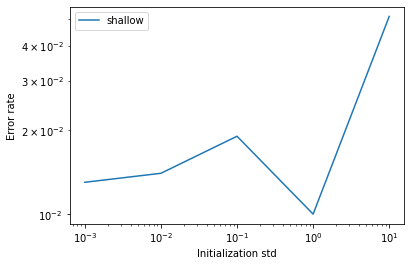

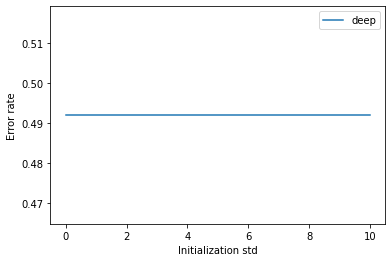

In [20]:
plt.figure()
plt.loglog(std, e_shallow, label="shallow")
# plt.loglog(std, e_deep, label="deep")
plt.ylabel("Error rate")
plt.xlabel("Initialization std")
plt.legend()
plt.show()

plt.figure()
plt.plot(std, e_deep, label="deep")
plt.ylabel("Error rate")
plt.xlabel("Initialization std")
plt.legend()
plt.show()